<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/manu/Efficient_Net_test_colab_240521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/X_train_update.csv',index_col=0)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/Y_train_CVw08PX.csv',index_col=0)

In [4]:
X.shape

(84916, 4)

In [5]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image name']

0        image_1263597046_product_3804725264.jpg
1         image_1008141237_product_436067568.jpg
2          image_938777978_product_201115110.jpg
3           image_457047496_product_50418756.jpg
4         image_1077757786_product_278535884.jpg
                          ...                   
84911      image_941495734_product_206719094.jpg
84912    image_1188462883_product_3065095706.jpg
84913     image_1009325617_product_440707564.jpg
84914    image_1267353403_product_3942400296.jpg
84915       image_684671297_product_57203227.jpg
Name: image name, Length: 84916, dtype: object

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:4800,:] #
y_val = y_train.iloc[:4800,:]
X_train = X_train.iloc[:43200,:] #
y_train = y_train.iloc[:43200,:]
X_test = X_test.iloc[:12000,:] #
y_test = y_test.iloc[:12000,:]

In [7]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [10]:
batch_size = 32
path = '/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/images tests/image_train'
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224), batch_size = batch_size)
val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val, directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224),batch_size = batch_size)
test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test, directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224), batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="image name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 43194 validated image filenames belonging to 27 classes.
Found 4800 validated image filenames belonging to 27 classes.
Found 12000 validated image filenames belonging to 27 classes.


In [11]:
pip install -U efficientnet

     |████████████████████████████████| 51kB 3.2MB/s 


In [12]:
import efficientnet.keras as efn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D

In [13]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
n_class = 27
model = Sequential()
model.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation="softmax")) #

from tensorflow.keras.optimizers import RMSprop
 # Compiling the model
model.compile(RMSprop(lr=0.0001, decay=1e-6),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                27675     
Total params: 68,303,543
Trainable params: 68,261,527
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
# Training the model for 5 epochs
history2 = model.fit_generator(train_generator, 
                                epochs = 5,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1350/1350 [==============================] - 11126s 8s/step - loss: 2.9062 - accuracy: 0.2378 - val_loss: 2.1004 - val_accuracy: 0.4004
Epoch 2/5
1350/1350 [==============================] - 660s 488ms/step - loss: 2.3004 - accuracy: 0.3512 - val_loss: 2.0115 - val_accuracy: 0.4252
Epoch 3/5
1350/1350 [==============================] - 659s 488ms/step - loss: 2.1777 - accuracy: 0.3827 - val_loss: 1.9194 - val_accuracy: 0.4527
Epoch 4/5
1350/1350 [==============================] - 657s 487ms/step - loss: 2.1397 - accuracy: 0.3933 - val_loss: 1.9058 - val_accuracy: 0.4721
Epoch 5/5
1350/1350 [==============================] - 656s 486ms/step - loss: 2.0918 - accuracy: 0.4055 - val_loss: 1.8721 - val_accuracy: 0.4740


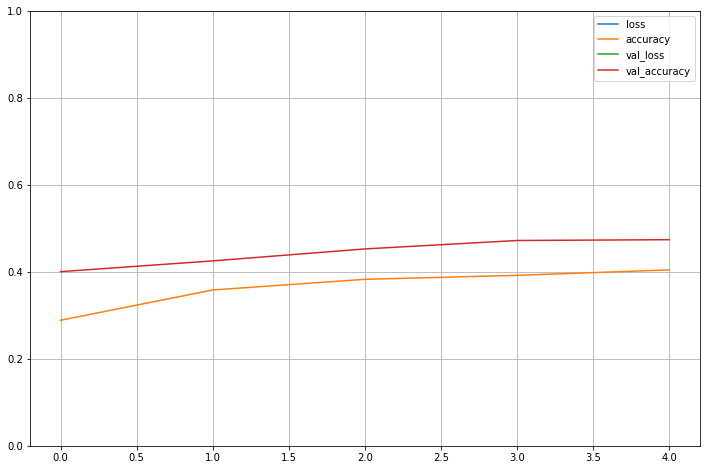

In [16]:
import pandas as pd
pd.DataFrame(history2.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [15]:
history2.save("my_DM1_model.h5")

AttributeError: ignored

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.keras.models.save_model(
    history.h5, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True, filepath='/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN'
)

AttributeError: ignored